Example notebook that does stuff with the output files from a xspec, namely:
* the .txt from wdata that saves the data/model,
* the *.fits from writefits that save out the fit parameters.

- IGH 14 Feb 2020 - Started  
- IGH 20 Feb 2020 - Better latex font, and fancier error label
- IGH 06 Oct 2022 - Changed file name

In [1]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import warnings
warnings.simplefilter('ignore')

# Some useful parameters
# norm = 1e-14/(4piD_A^2)*\int n_e n_p dV
# The norm factor from the XSPEC APEC model is defined here: https://heasarc.gsfc.nasa.gov/xanadu/xspec/manual/node134.html
kev2mk=0.0861733
emfact=3.5557e-42

In [2]:
# An example file produced from writefits using FPMA and FPMA and a model of const*apec
hdumok = fits.open('mod_thf2prb.fits')
# hdumok.info()
mokprm=hdumok[1].data
mokcol=hdumok[1].columns.names
hdumok.close()
print(mokcol)

['DIRPATH', 'PHAFILE', 'BACKFILE', 'RESPFILE', 'ARFFILE', 'EXPOSURE', 'STATISTIC', 'kT2', 'EkT2', 'norm5', 'Enorm5', 'factor6', 'Efactor6', 'kT7', 'EkT7', 'Abundanc8', 'EAbundanc8', 'Redshift9', 'ERedshift9', 'norm10', 'Enorm10']


In [3]:
t1=mokprm['kt2'][0]/kev2mk
t1_cr=mokprm['ekt2'][0]/kev2mk
print('T1: ',t1,'MK, Err Rng: ',t1_cr)
em1=np.double(mokprm['norm5'][0])/emfact
em1_cr=np.double(mokprm['enorm5'][0])/emfact
print('EM1: ',em1,'cm^-3, Err Rng: ',em1_cr)
fac=mokprm['factor6'][0]
fac_cr=mokprm['efactor6'][0]
print('Fac: ',fac,' Fac Rng: ',fac_cr)

T1:  4.057312357339133 MK, Err Rng:  [4.0522065 4.0625744]
EM1:  4.862277469977783e+46 cm^-3, Err Rng:  [4.79379412e+46 4.93071116e+46]
Fac:  1.05385  Fac Rng:  [1.0454307 1.0623616]


In [4]:
# An example file produced from wdata from an iplot ldata ufspec delchi
dd=[]
with open('mod_thf2prb.txt', 'r') as f:
    lines = f.readlines()
    dd.append(lines)
# Get's rid of the first 3 lines which are normally not the data
dd=dd[0][3:]

In [5]:
# Different plots separated by 'NO NO NO NO NO\n' so need to find where this occurs
id_break=[i for i, value in enumerate(dd) if value == 'NO NO NO NO NO\n']

dd_ld=dd[:id_break[0]]
dd_uf=dd[id_break[0]+1:id_break[1]]
dd_dc=dd[id_break[1]+1:]

# For this example just assign the ldata plot
eng_ld=[]
deng_ld=[]
data_ld=[]
edata_ld=[]
mod_ld=[]
for i in dd_ld:
    temp_ld=i.split()
    eng_ld.append(float(temp_ld[0]))
    deng_ld.append(float(temp_ld[1]))
    data_ld.append(float(temp_ld[2]))
    edata_ld.append(float(temp_ld[3]))
    mod_ld.append(float(temp_ld[4]))
    
eng_ld=np.array(eng_ld)
deng_ld=np.array(deng_ld)
data_ld=np.array(data_ld)
edata_ld=np.array(edata_ld)
mod_ld=np.array(mod_ld)


In [6]:
# # Setup the font used for plotting
matplotlib.rcParams['font.sans-serif'] = "Arial"
matplotlib.rcParams['font.family'] = "sans-serif"
matplotlib.rcParams['font.size'] = 18
matplotlib.rcParams['mathtext.default']="regular"

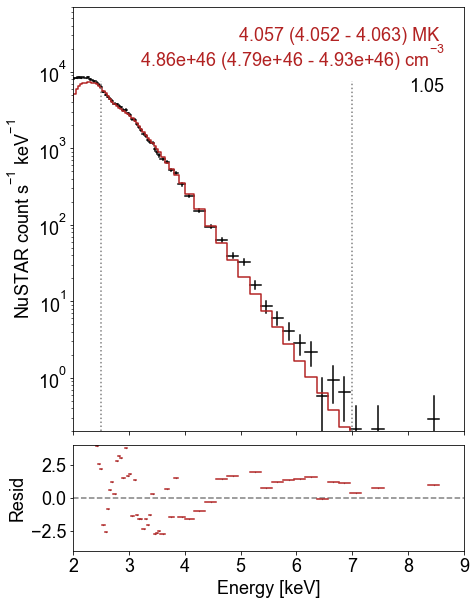

In [7]:
# A lot of this is just to get the plot exactly how I want it 

fig,axs=plt.subplots(2,1,figsize=(7,10),gridspec_kw=dict( height_ratios=[4,1],hspace=0.05))

#  Plot the data and model fit on the top plot
axs[0].semilogy(eng_ld,data_ld,'.',ms=0.5,color='k')
for i in np.arange(len(data_ld)):
    axs[0].plot([eng_ld[i],eng_ld[i]],[data_ld[i]-edata_ld[i],data_ld[i]+edata_ld[i]],color='k')
    axs[0].plot([eng_ld[i]-deng_ld[i],eng_ld[i]+deng_ld[i]],[data_ld[i],data_ld[i]],color='k')
axs[0].plot(eng_ld,mod_ld,color='firebrick',drawstyle='steps-mid')
axs[0].set_ylabel('NuSTAR count s$^{-1}$ keV$^{-1}$')
ylim=[2e-1,7e4]
xlim=[2,9]
axs[0].set_ylim(ylim)
for aa in axs:
    aa.set_xlim(xlim)
    aa.label_outer()
    
# Put the actual fit values on the top plot
param_labelt="{0:5.3f} ({1:5.3f} - {2:5.3f}) MK ".format(t1,t1_cr[0],t1_cr[1])
param_labelem="{0:5.2e} ({1:5.2e} - {2:5.2e}) ".format(em1,em1_cr[0],em1_cr[1])+"$cm^{-3}$"
axs[0].text(0.95,0.92,param_labelt,color='firebrick',ha='right',transform=axs[0].transAxes)
axs[0].text(0.95,0.86,param_labelem,color='firebrick',ha='right',transform=axs[0].transAxes)
axs[0].text(0.95,0.80,"{0:4.2f}".format(fac),color='k',ha='right',transform=axs[0].transAxes)

# You need to specify this yourself
fiter=[2.5,7.0]
axs[0].plot([fiter[0],fiter[0]],[ylim[0],10**(0.8*np.log10(ylim[1]))],':',color='grey')
axs[0].plot([fiter[1],fiter[1]],[ylim[0],10**(0.8*np.log10(ylim[1]))],':',color='grey')

# Calculate and plot the residuals on the bottom plot
resid=(data_ld-mod_ld)/edata_ld
axs[1].plot(eng_ld,resid,'.',ms=0.5,color='k')
axs[1].set_ylim([-4,4])
axs[1].set_xlabel('Energy [keV]')
axs[1].plot(xlim,[0,0],'--',color='grey')
for i in np.arange(len(data_ld)):
    axs[1].plot([eng_ld[i]-deng_ld[i],eng_ld[i]+deng_ld[i]],[resid[i],resid[i]],color='firebrick')
axs[1].set_ylabel('Resid')
plt.show()
    

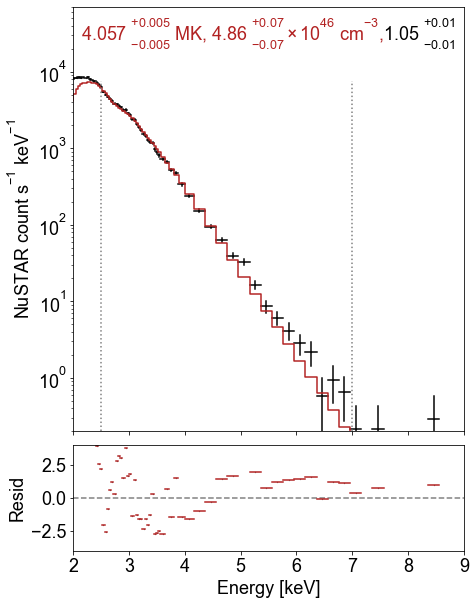

In [8]:
# Same as above but just a fancier way of plotting the error ranges 
fig,axs=plt.subplots(2,1,figsize=(7,10),gridspec_kw=dict( height_ratios=[4,1],hspace=0.05))

#  Plot the data and model fit on the top plot
axs[0].semilogy(eng_ld,data_ld,'.',ms=0.5,color='k')
for i in np.arange(len(data_ld)):
    axs[0].plot([eng_ld[i],eng_ld[i]],[data_ld[i]-edata_ld[i],data_ld[i]+edata_ld[i]],color='k')
    axs[0].plot([eng_ld[i]-deng_ld[i],eng_ld[i]+deng_ld[i]],[data_ld[i],data_ld[i]],color='k')
axs[0].plot(eng_ld,mod_ld,color='firebrick',drawstyle='steps-mid')
axs[0].set_ylabel('NuSTAR count s$^{-1}$ keV$^{-1}$')
ylim=[2e-1,7e4]
xlim=[2,9]
axs[0].set_ylim(ylim)
for aa in axs:
    aa.set_xlim(xlim)
    aa.label_outer()
    
# Put the actual fit values on the top plot
labt="{0:5.3f}".format(t1)
labtup="{0:5.3f}".format(t1_cr[1]-t1)
labtlw="{0:5.3f}".format(t1-t1_cr[0])

powem1=np.floor(np.log10(em1))
labpowem1="{0:2d}".format(int(powem1))

labem="{0:5.2f}".format(em1/10**powem1)
labemup="{0:5.2f}".format((em1_cr[1]-em1)/10**powem1)
labemlw="{0:5.2f}".format((em1-em1_cr[0])/10**powem1)

labf="{0:5.2f}".format(fac)
labfup="{0:5.2f}".format(fac_cr[1]-fac)
labflw="{0:5.2f}".format(fac-fac_cr[0])

axs[0].text(0.02,0.92,labt+" $^{+"+labtup+"}_{-"+labtlw+"}\;MK,$",color='firebrick',ha='left',transform=axs[0].transAxes)
axs[0].text(0.34,0.92,labem+" $^{+"+labemup+"}_{-"+labemlw+"}\,×\,10^{"+labpowem1+"}\;cm^{-3},$",color='firebrick',ha='left',transform=axs[0].transAxes)
axs[0].text(0.78,0.92,labf+" $^{+"+labfup+"}_{-"+labflw+"}$",color='k',ha='left',transform=axs[0].transAxes)

# You need to specify this yourself
fiter=[2.5,7.0]
axs[0].plot([fiter[0],fiter[0]],[ylim[0],10**(0.8*np.log10(ylim[1]))],':',color='grey')
axs[0].plot([fiter[1],fiter[1]],[ylim[0],10**(0.8*np.log10(ylim[1]))],':',color='grey')

# Calculate and plot the residuals on the bottom plot
resid=(data_ld-mod_ld)/edata_ld
axs[1].plot(eng_ld,resid,'.',ms=0.5,color='k')
axs[1].set_ylim([-4,4])
axs[1].set_xlabel('Energy [keV]')
axs[1].plot(xlim,[0,0],'--',color='grey')
for i in np.arange(len(data_ld)):
    axs[1].plot([eng_ld[i]-deng_ld[i],eng_ld[i]+deng_ld[i]],[resid[i],resid[i]],color='firebrick')
axs[1].set_ylabel('Resid')
plt.show()
    